In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

r = robjects.r

nsn = importr("NanoStringNorm")
egr = importr("edgeR")

py = pandas2ri.ri2py

In [4]:
cell_type = 'Tcon'

# Read in RCC data

In [5]:
base_path = u'/home/gus/MEGAsync/zim/main/BCH/Projects/James/Nanostring_pipeline/OKT3/data/compare_ours_to_existing/tcon'

our_rcc_path = base_path+u"/ours"
thr_rcc_path = base_path+u"/theirs"

In [6]:
our_data = py(r(u"""read.markup.RCC(rcc.path="{PATH}")""".format(PATH=our_rcc_path)).rx2('x'))
thr_data = py(r(u"""read.markup.RCC(rcc.path="{PATH}")""".format(PATH=thr_rcc_path)).rx2('x'))

In [7]:
our_data.shape

(608, 9)

In [8]:
thr_data.shape

(540, 6)

In [9]:
our_data.head()

,CodeClass,Name,Accession,BWH006_Tcon_w0_08,BWH008_Tcon_w0_05,MGH001_Tcon_w0_01,MGH002_Tcon_w0_01,MGH004_Tcon_w0_05,MGH007_Tcon_w0_11
1,Endogenous,VTN,NM_000638.3,0,1,3,0,2,0
2,Endogenous,HLA-DQB1,NM_002123.3,3,3,6,1,0,0
3,Endogenous,KIT,NM_000222.2,3,1,3,0,2,0
4,Endogenous,LAG3,NM_002286.5,1,2,3,0,6,1
5,Endogenous,SOCS3,NM_003955.3,35,78,11,0,19,26


In [10]:
our_genes = set(our_data.Name.unique())
thr_genes = set(thr_data.Name.unique())

In [11]:
len(our_genes.intersection(thr_genes))

520

## Join tables by gene names

- We will only deal with the genes that are in commen between the tables from now on
- thats 520 including the pos/neg controls etc.

In [12]:
cmb_data = pd.merge(left=our_data, right=thr_data,
                    how='inner', on="Name",
                    left_on=None, right_on=None,
                    left_index=False, right_index=False,
                    sort=False, suffixes=('_OUR', '_THR'), copy=True, indicator=False)

cmb_data.index = cmb_data.Name.values
cmb_data = cmb_data.drop(labels=['Name'],axis=1)
cmb_data.head()

,CodeClass_OUR,Accession_OUR,BWH006_Tcon_w0_08,BWH008_Tcon_w0_05,MGH001_Tcon_w0_01,MGH002_Tcon_w0_01,MGH004_Tcon_w0_05,MGH007_Tcon_w0_11,CodeClass_THR,Accession_THR,GSM1515482_Tcon,GSM1515485_Tcon,GSM1515488_Tcon
VTN,Endogenous,NM_000638.3,0,1,3,0,2,0,Endogenous,NM_000638.3,13,4,25
HLA-DQB1,Endogenous,NM_002123.3,3,3,6,1,0,0,Endogenous,NM_002123.3,10,3,12
KIT,Endogenous,NM_000222.2,3,1,3,0,2,0,Endogenous,NM_000222.1,59,15,65
SOCS3,Endogenous,NM_003955.3,35,78,11,0,19,26,Endogenous,NM_003955.3,111,44,139
TCF7,Endogenous,NM_003202.2,92,200,10,2,305,85,Endogenous,NM_003202.2,586,421,492


In [13]:
code_class_missmatch = cmb_data.CodeClass_OUR != cmb_data.CodeClass_THR
sum(code_class_missmatch)

15

15 rows have CodeClass designations that don't match up...

In [14]:
cmb_data[code_class_missmatch][['CodeClass_OUR','CodeClass_THR']]

,CodeClass_OUR,CodeClass_THR
EEF1G,Housekeeping,Endogenous
TUBB,Housekeeping,Endogenous
TBP,Housekeeping,Endogenous
POLR2A,Housekeeping,Endogenous
GUSB,Housekeeping,Endogenous
HPRT1,Housekeeping,Endogenous
GAPDH,Housekeeping,Endogenous
SDHA,Housekeeping,Endogenous
OAZ1,Housekeeping,Endogenous
PPIA,Housekeeping,Endogenous


Looks like its not too big a deal.  They just added some genes as housekeepers.

## OK lets get rid of CodeClass and Accession Columns and write to file

In [15]:
cmb_data_extra_cols = cmb_data[['CodeClass_OUR','Accession_OUR','CodeClass_THR','Accession_THR']].copy()

cmb_data = cmb_data.drop(labels=['CodeClass_OUR','Accession_OUR','CodeClass_THR','Accession_THR'],axis=1)

In [16]:
print cmb_data.columns.values

['BWH006_Tcon_w0_08' 'BWH008_Tcon_w0_05' 'MGH001_Tcon_w0_01'
 'MGH002_Tcon_w0_01' 'MGH004_Tcon_w0_05' 'MGH007_Tcon_w0_11'
 'GSM1515482_Tcon' 'GSM1515485_Tcon' 'GSM1515488_Tcon']


In [17]:
cmb_data_path = base_path+u"/combo_nanostring_data.csv"
cmb_data.to_csv(path_or_buf=cmb_data_path, 
           columns=None, header=True, index=True,)

## Write out the target table

In [18]:
targets = cmb_data.T.iloc[:,0:2].copy()
targets[u'source'] = targets.index.values
targets.source = targets.source.apply(lambda i: 'THEIRS' if i.startswith('GSM') else 'OURS' )
targets = pd.DataFrame(targets.source)
targets

,source
BWH006_Tcon_w0_08,OURS
BWH008_Tcon_w0_05,OURS
MGH001_Tcon_w0_01,OURS
MGH002_Tcon_w0_01,OURS
MGH004_Tcon_w0_05,OURS
MGH007_Tcon_w0_11,OURS
GSM1515482_Tcon,THEIRS
GSM1515485_Tcon,THEIRS
GSM1515488_Tcon,THEIRS


In [19]:
targets_path = base_path+u"/targets.csv"
targets.to_csv(path_or_buf=targets_path, 
           columns=None, header=True, index=True)

# EdgeR is used to perform normalization

In [20]:
x = py(r(u"""x <- read.delim("{PATH}", sep = ',', row.names=1) """.format(PATH=cmb_data_path)))

# Sort column names
x = py(r(u""" x <- x[,order(colnames(x))] """))

In [21]:
print r(u"head(x)")

         BWH006_Tcon_w0_08 BWH008_Tcon_w0_05 GSM1515482_Tcon GSM1515485_Tcon
VTN                      0                 1              13               4
HLA-DQB1                 3                 3              10               3
KIT                      3                 1              59              15
SOCS3                   35                78             111              44
TCF7                    92               200             586             421
IKBKB                    7                20              99              60
         GSM1515488_Tcon MGH001_Tcon_w0_01 MGH002_Tcon_w0_01 MGH004_Tcon_w0_05
VTN                   25                 3                 0                 2
HLA-DQB1              12                 6                 1                 0
KIT                   65                 3                 0                 2
SOCS3                139                11                 0                19
TCF7                 492                10                 2      

In [22]:
x.head()

,BWH006_Tcon_w0_08,BWH008_Tcon_w0_05,GSM1515482_Tcon,GSM1515485_Tcon,GSM1515488_Tcon,MGH001_Tcon_w0_01,MGH002_Tcon_w0_01,MGH004_Tcon_w0_05,MGH007_Tcon_w0_11
VTN,0,1,13,4,25,3,0,2,0
HLA-DQB1,3,3,10,3,12,6,1,0,0
KIT,3,1,59,15,65,3,0,2,0
SOCS3,35,78,111,44,139,11,0,19,26
TCF7,92,200,586,421,492,10,2,305,85


In [23]:
r("""# read in target annotations for the design matrix stuff later
targets <- read.table("{PATH}",sep = ',', header = TRUE, row.names = 1)
#targets <- targets[order(rownames(targets)),]
targets <- lapply(targets,factor)

# create the DEGList object
y <- DGEList(counts=x,group=targets$source)


# Filter for counts
#keep <- rowSums(y>30) >= 2
#y <- y[keep, , keep.lib.sizes=FALSE]

# TMM normalization factors
y <- calcNormFactors(y)
""".format(PATH=targets_path))

<ListVector - Python:0x7f3c81009098 / R:0x75aad20>
[Matrix, DataFrame]
  counts: <class 'rpy2.robjects.vectors.Matrix'>
  <Matrix - Python:0x7f3c81008638 / R:0x8107170>
[       0,        3,        3, ...,        0,       13,        2]
<ListVector - Python:0x7f3c81009098 / R:0x75aad20>
[Matrix, DataFrame]

In [24]:
n = py(r("n <- cpm(y)"))
n_rows = py(r("rownames(n)"))
n_cols = py(r("colnames(n)"))

In [25]:
y_norm = pd.DataFrame(n, columns=n_cols, index=n_rows)

In [26]:
y_norm.T

,VTN,HLA-DQB1,KIT,SOCS3,TCF7,IKBKB,ITGA6,CXCR4,NFKBIZ,MAPK14,...,HPRT1,GAPDH,SDHA,OAZ1,PPIA,G6PD,RPL19,POLR1B,ABCF1,ALAS1
BWH006_Tcon_w0_08,0.000000,97.295143,97.295143,1135.109999,2983.717712,227.022000,1167.541713,5026.915710,1102.678285,551.339142,...,227.022000,1978.334570,227.022000,1070.246571,259.453714,129.726857,13459.161418,32.431714,162.158571,64.863429
BWH008_Tcon_w0_05,14.664944,43.994833,14.664944,1143.865662,2932.988877,293.298888,1143.865662,3886.210262,689.252386,542.602942,...,337.293721,2537.035379,278.633943,1070.540940,205.309221,131.984499,16586.052101,117.319555,351.958665,102.654611
GSM1515482_Tcon,52.949966,40.730743,240.311385,452.111250,2386.821553,403.234358,1205.629999,1225.995371,1568.133614,484.695844,...,73.315338,346.211317,488.768919,57.023041,281.042128,175.142196,2325.725438,69.242263,252.530608,69.242263
GSM1515485_Tcon,33.828924,25.371693,126.858466,372.118168,3560.494290,507.433866,1454.643748,1987.449307,1801.390223,431.318786,...,50.743387,304.460319,439.776017,50.743387,262.174164,135.315697,2638.656101,59.200618,279.088626,50.743387
GSM1515488_Tcon,84.515433,40.567408,219.740125,469.905807,1663.263718,297.494324,780.922599,1487.471618,1061.513836,351.584201,...,91.276667,240.023829,398.912843,77.754198,260.307533,131.844075,2751.822493,57.470494,155.508396,64.231729
MGH001_Tcon_w0_01,61.386762,122.773524,61.386762,225.084795,204.622541,163.698033,143.235779,920.801433,368.320573,204.622541,...,81.849016,347.858319,204.622541,225.084795,143.235779,40.924508,1084.499466,61.386762,122.773524,143.235779
MGH002_Tcon_w0_01,0.000000,82.979847,0.000000,0.000000,165.959695,0.000000,82.979847,248.939542,0.000000,82.979847,...,165.959695,165.959695,0.000000,165.959695,0.000000,0.000000,1078.738016,82.979847,165.959695,0.000000
MGH004_Tcon_w0_05,26.877817,0.000000,26.877817,255.339263,4098.867113,376.289440,1357.329765,2754.976256,792.895605,658.506520,...,241.900354,2701.220622,524.117434,1518.596668,174.705811,80.633451,22819.266747,94.072360,403.167257,40.316726
MGH007_Tcon_w0_11,0.000000,0.000000,0.000000,717.477175,2345.598457,275.952760,1324.573247,5684.626850,910.644107,441.524416,...,303.548036,2069.645698,220.762208,1048.620487,275.952760,27.595276,16584.760858,0.000000,358.738588,55.190552


In [27]:
cmb_cpm = pd.merge(left=targets, right=y_norm.T, 
                   how='inner', on=None, 
                   left_on=None, right_on=None, 
                   left_index=True, right_index=True, 
                   sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

In [28]:
cmb_cpm_mean = cmb_cpm.groupby('source').mean()
cmb_cpm_mean = cmb_cpm_mean.T

/home/gus/anaconda2/envs/stack2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


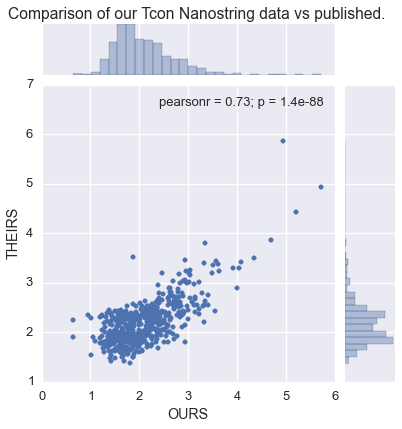

In [29]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean+1), kind='scatter',
             );

plt.suptitle("Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

### Lets look at the external controls

In [30]:
cmb_data_extra_cols.head()

,CodeClass_OUR,Accession_OUR,CodeClass_THR,Accession_THR
VTN,Endogenous,NM_000638.3,Endogenous,NM_000638.3
HLA-DQB1,Endogenous,NM_002123.3,Endogenous,NM_002123.3
KIT,Endogenous,NM_000222.2,Endogenous,NM_000222.1
SOCS3,Endogenous,NM_003955.3,Endogenous,NM_003955.3
TCF7,Endogenous,NM_003202.2,Endogenous,NM_003202.2


In [31]:
cmb_data_extra_cols.CodeClass_OUR.unique()

array(['Endogenous', 'Positive', 'Negative', 'Housekeeping'], dtype=object)

In [32]:
cmb_data_extra_cols.CodeClass_THR.unique()

array(['Endogenous', 'Positive', 'Negative'], dtype=object)

In [33]:
pos_ctrl = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Positive" """).index.values)
neg_ctrl = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Negative" """).index.values)
hsk_gene = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Housekeeping" """).index.values)
bth_ctrl = pos_ctrl + neg_ctrl
pan_gene = list(cmb_data_extra_cols[cmb_data_extra_cols.CodeClass_OUR.apply(lambda i: i in ['Housekeeping','Endogenous'])].index.values)

In [34]:
bth_ctrl

['POS_C(8)',
 'POS_A(128)',
 'POS_F(0.125)',
 'POS_D(2)',
 'POS_B(32)',
 'POS_E(0.5)',
 'NEG_C(0)',
 'NEG_D(0)',
 'NEG_E(0)',
 'NEG_A(0)',
 'NEG_H(0)',
 'NEG_G(0)',
 'NEG_F(0)',
 'NEG_B(0)']

In [35]:
cmb_cpm_mean.head()

source,OURS,THEIRS
VTN,17.154921,57.098108
HLA-DQB1,57.840558,35.556615
KIT,33.370778,195.636659
SOCS3,579.479482,431.378408
TCF7,2121.959066,2536.859854


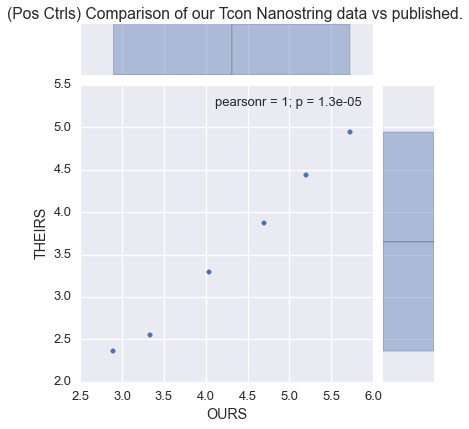

In [36]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[pos_ctrl]+1), kind='scatter',
             );

plt.suptitle("(Pos Ctrls) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

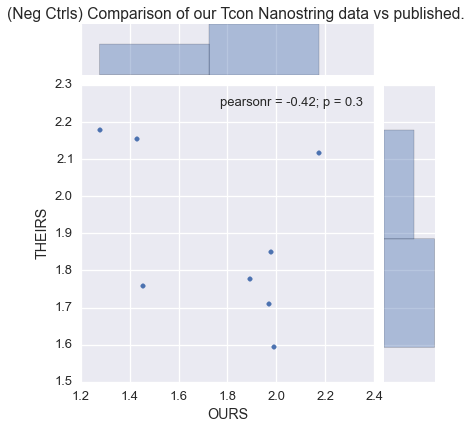

In [37]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[neg_ctrl]+1), kind='scatter',
             );

plt.suptitle("(Neg Ctrls) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

In [38]:
cmb_cpm_mean.loc[neg_ctrl].head()

source,OURS,THEIRS
NEG_C(0),149.136107,129.680307
NEG_D(0),27.489090,56.213430
NEG_E(0),76.777841,58.694202
NEG_A(0),94.056536,69.786553
NEG_H(0),17.876231,149.623318


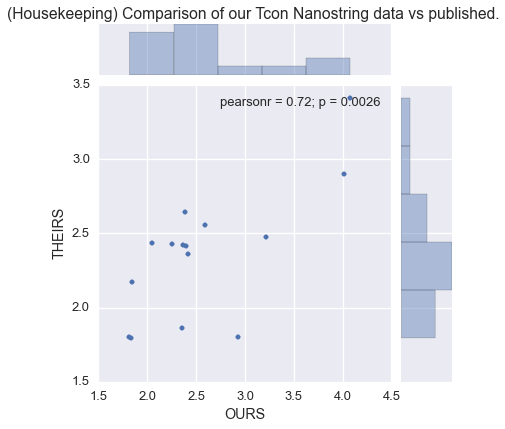

In [39]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[hsk_gene]+1), kind='scatter',
             );

plt.suptitle("(Housekeeping) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

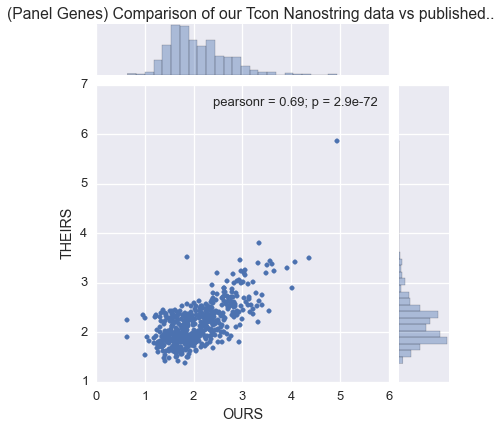

In [40]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[pan_gene]+1), kind='scatter',
             );

plt.suptitle("(Panel Genes) Comparison of our {cell} Nanostring data vs published..".format(cell=cell_type), y=1,);